In [1]:
import boto3
import botocore
import sagemaker
import sys
import pandas as pd
%matplotlib inline

In [2]:
bucket = 'scientist-13-jon'   # <--- specify a bucket you have access to
prefix = 'sagemaker/fraud'
execution_role = sagemaker.get_execution_role()


# check if the bucket exists
try:
    boto3.Session().client('s3').head_bucket(Bucket=bucket)
except botocore.exceptions.ParamValidationError as e:
    print('Hey! You either forgot to specify your S3 bucket'
          ' or you gave your bucket an invalid name!')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == '403':
        print("Hey! You don't have permission to access the bucket, {}.".format(bucket))
    elif e.response['Error']['Code'] == '404':
        print("Hey! Your bucket, {}, doesn't exist!".format(bucket))
    else:
        raise
else:
    print('Training input/output will be stored in: s3://{}/{}'.format(bucket, prefix))

Training input/output will be stored in: s3://scientist-13-jon/sagemaker/fraud


In [3]:
df = pd.read_csv("crimes.csv.zip")

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.type.unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [6]:
df = pd.get_dummies(df, prefix=['type'], columns=['type'])

In [7]:
df.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,0,0,1,0
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,0,0,1,0
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,0,0,0,1
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,1,0,0,0
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,0,0,1,0


In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
amount_scaler = MinMaxScaler()
scaled_amt_df = amount_scaler.partial_fit(df[['amount']])

oldbalanceOrg_scaler = MinMaxScaler()
scaled_oldbalanceOrg_df = oldbalanceOrg_scaler.partial_fit(df[['oldbalanceOrg']])

newbalanceOrig_scaler = MinMaxScaler()
scaled_newbalanceOrig_df = newbalanceOrig_scaler.partial_fit(df[['newbalanceOrig']])

oldbalanceDest_scaler = MinMaxScaler()
scaled_oldbalanceDest_df = oldbalanceDest_scaler.partial_fit(df[['oldbalanceDest']])

newbalanceDest_scaler = MinMaxScaler()
scaled_newbalanceDest_df = newbalanceDest_scaler.partial_fit(df[['newbalanceDest']])

In [10]:
amt_scaled = scaled_amt_df.transform(df[['amount']])
oldbalanceOrg_scaled = scaled_oldbalanceOrg_df.transform(df[['oldbalanceOrg']])
newbalanceOrig_scaled = scaled_newbalanceOrig_df.transform(df[['newbalanceOrig']])
oldbalanceDest_scaled = scaled_oldbalanceDest_df.transform(df[['oldbalanceDest']])
newbalanceDest_scaled = scaled_newbalanceDest_df.transform(df[['newbalanceDest']])

In [11]:
df = df.assign(amt_scaled=pd.DataFrame(amt_scaled, columns=['amt_scaled']))
df = df.assign(oldbalanceOrg_scaled=pd.DataFrame(oldbalanceOrg_scaled, columns=['oldbalanceOrg']))
df = df.assign(newbalanceOrig_scaled=pd.DataFrame(newbalanceOrig_scaled, columns=['newbalanceOrig']))
df = df.assign(oldbalanceDest_scaled=pd.DataFrame(oldbalanceDest_scaled, columns=['oldbalanceDest']))
df = df.assign(newbalanceDest_scaled=pd.DataFrame(newbalanceDest_scaled, columns=['newbalanceDest']))


In [12]:
df.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,amt_scaled,oldbalanceOrg_scaled,newbalanceOrig_scaled,oldbalanceDest_scaled,newbalanceDest_scaled
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,0,0,1,0,0.000106,0.002855,0.003233,0.000000,0.0
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,0,0,1,0,0.000020,0.000357,0.000391,0.000000,0.0
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,0,0,0,1,0.000002,0.000003,0.000000,0.000000,0.0
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,1,0,0,0,0.000002,0.000003,0.000000,0.000059,0.0
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,0,0,1,0,0.000126,0.000697,0.000603,0.000000,0.0


In [13]:
df = df.drop(columns=['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'])


In [14]:
df.head()

,step,nameOrig,nameDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,amt_scaled,oldbalanceOrg_scaled,newbalanceOrig_scaled,oldbalanceDest_scaled,newbalanceDest_scaled
0,1,C1231006815,M1979787155,0,0,0,0,0,1,0,0.000106,0.002855,0.003233,0.000000,0.0
1,1,C1666544295,M2044282225,0,0,0,0,0,1,0,0.000020,0.000357,0.000391,0.000000,0.0
2,1,C1305486145,C553264065,1,0,0,0,0,0,1,0.000002,0.000003,0.000000,0.000000,0.0
3,1,C840083671,C38997010,1,0,0,1,0,0,0,0.000002,0.000003,0.000000,0.000059,0.0
4,1,C2048537720,M1230701703,0,0,0,0,0,1,0,0.000126,0.000697,0.000603,0.000000,0.0


In [15]:
import numpy as np
from sklearn.model_selection import train_test_split

def create_training_sets(data):
    ys = data[['isFraud']]
    
    #ys -= 1
    
    drop_list = ['step', 'nameOrig', 'nameDest', 'isFlaggedFraud', 'isFraud']
    
    xs = data.drop(columns=drop_list)
    
    np.random.seed(13)

    train_features, test_features, train_labels, test_labels = train_test_split(
    xs, ys, test_size=0.2)
    
    val_features, test_features, val_labels, test_labels = train_test_split(
    test_features, test_labels, test_size=0.5)
    
    return train_features, test_features, train_labels, test_labels, val_features, val_labels
     
    
train_features, test_features, train_labels, test_labels, val_features, val_labels = create_training_sets(df)

In [16]:
train_features.isna().sum()

type_CASH_IN             0
type_CASH_OUT            0
type_DEBIT               0
type_PAYMENT             0
type_TRANSFER            0
amt_scaled               0
oldbalanceOrg_scaled     0
newbalanceOrig_scaled    0
oldbalanceDest_scaled    0
newbalanceDest_scaled    0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c2d57ef60>]],
      dtype=object)

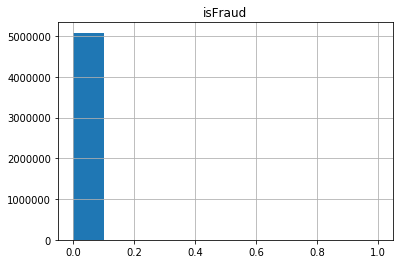

In [17]:
train_labels.hist()

In [18]:
train_features.head()

,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,amt_scaled,oldbalanceOrg_scaled,newbalanceOrig_scaled,oldbalanceDest_scaled,newbalanceDest_scaled
5692930,1,0,0,0,0,0.002010,0.042642,0.054989,0.000942,0.000420
2987111,0,0,0,1,0,0.000104,0.000938,0.000933,0.000000,0.000000
6214257,1,0,0,0,0,0.002460,0.000112,0.004720,0.002626,0.001986
1168428,0,0,0,1,0,0.000106,0.000393,0.000275,0.000000,0.000000
2588951,0,1,0,0,0,0.000200,0.000000,0.000000,0.002313,0.002364


## Thoughts about passing the labels

The taxi data in the RCF example is only a single column. We need to add the whole dataset. 
https://github.com/numenta/NAB/blob/master/data/realKnownCause/nyc_taxi.csv

However, we're training an unsupervised model, so we shouldn't be passing in the labels?
https://sagemaker.readthedocs.io/en/stable/randomcutforest.html?highlight=random

In [19]:
from sagemaker import RandomCutForest

session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=512,
                      num_trees=50)

## I wanted to get a validation set passed into .fit, but had issues getting it working

In [20]:
# automatically upload the training data to S3 and run the training job
#rcf.fit(rcf.record_set(df.isFraud.as_matrix().reshape(-1,1)))
train_channel = rcf.record_set(train_features.as_matrix(), channel='train')
#validation_channel = rcf.record_set(test_features.as_matrix(), channel='validation')

#data_channels = {'train': train_channel, 'validation': validation_channel}
rcf.fit(train_channel, logs=True)


INFO:sagemaker:Creating training-job with name: randomcutforest-2019-03-14-18-23-57-202


2019-03-14 18:23:57 Starting - Starting the training job...
2019-03-14 18:24:01 Starting - Launching requested ML instances......
2019-03-14 18:25:11 Starting - Preparing the instances for training...
2019-03-14 18:25:55 Downloading - Downloading input data...
2019-03-14 18:26:10 Training - Downloading the training image.....
Docker entrypoint called with argument(s): train
[03/14/2019 18:27:03 INFO 140174619391808] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[03/14/2019 18:27:03 INFO 140174619391808] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'mini_bat


2019-03-14 18:27:25 Uploading - Uploading generated training model
2019-03-14 18:27:25 Completed - Training job completed
[2019-03-14 18:27:14.044] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 1, "duration": 8895, "num_examples": 5091, "num_bytes": 529369984}
[03/14/2019 18:27:14 INFO 140174619391808] Sampling training data completed.
#metrics {"Metrics": {"epochs": {"count": 1, "max": 1, "sum": 1.0, "min": 1}, "update.time": {"count": 1, "max": 8910.895824432373, "sum": 8910.895824432373, "min": 8910.895824432373}}, "EndTime": 1552588034.059052, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "RandomCutForest"}, "StartTime": 1552588025.135095}

[03/14/2019 18:27:14 INFO 140174619391808] Early stop condition met. Stopping training.
[03/14/2019 18:27:14 INFO 140174619391808] #progress_metric: host=algo-1, completed 100 % epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 5091, "sum": 5091.0,

In [21]:
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

INFO:sagemaker:Creating model with name: randomcutforest-2019-03-14-18-27-39-092
INFO:sagemaker:Creating endpoint with name randomcutforest-2019-03-14-18-23-57-202


---------------------------------------------------------------------------------------!

In [22]:
print('Endpoint name: {}'.format(rcf_inference.endpoint))

Endpoint name: randomcutforest-2019-03-14-18-23-57-202


In [23]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer


## Let's run some predictions!

In [24]:
test_features.head()

,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,amt_scaled,oldbalanceOrg_scaled,newbalanceOrig_scaled,oldbalanceDest_scaled,newbalanceDest_scaled
1912535,1,0,0,0,0,0.003061,0.000768,0.006629,0.000000,0.000000
657468,0,0,0,1,0,0.000057,0.000000,0.000000,0.000000,0.000000
2905321,0,0,0,1,0,0.000011,0.000000,0.000000,0.000000,0.000000
5357700,0,1,0,0,0,0.000953,0.000071,0.000000,0.012552,0.012794
1016367,0,0,0,1,0,0.000068,0.000000,0.000000,0.000000,0.000000


In [25]:
df_numpy = test_features.as_matrix()
print(df_numpy[:1])
#results = rcf_inference.predict(df_numpy[:6])

[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.06082091e-03 7.67558429e-04 6.62889790e-03
  0.00000000e+00 0.00000000e+00]]


I was getting timeout errors running the predictions against the 6million rows, so let's do a subset.

That was earlier, now let's use the test or validation set.

In [26]:
samples = 30000
df_numpy = test_features[:samples]
df_numpy = df_numpy.sort_index()
labels = test_labels[:samples]
labels = labels.sort_index()

In [27]:
test_features.head()

,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,amt_scaled,oldbalanceOrg_scaled,newbalanceOrig_scaled,oldbalanceDest_scaled,newbalanceDest_scaled
1912535,1,0,0,0,0,0.003061,0.000768,0.006629,0.000000,0.000000
657468,0,0,0,1,0,0.000057,0.000000,0.000000,0.000000,0.000000
2905321,0,0,0,1,0,0.000011,0.000000,0.000000,0.000000,0.000000
5357700,0,1,0,0,0,0.000953,0.000071,0.000000,0.012552,0.012794
1016367,0,0,0,1,0,0.000068,0.000000,0.000000,0.000000,0.000000


In [28]:
test_features.describe()

,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,amt_scaled,oldbalanceOrg_scaled,newbalanceOrig_scaled,oldbalanceDest_scaled,newbalanceDest_scaled
count,636262.000000,636262.000000,636262.000000,636262.000000,636262.000000,636262.000000,636262.000000,636262.000000,636262.000000,636262.000000
mean,0.219771,0.350717,0.006445,0.339080,0.083986,0.001947,0.014004,0.017255,0.003077,0.003426
std,0.414092,0.477195,0.080025,0.473398,0.277367,0.006623,0.048428,0.058928,0.009591,0.010398
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000144,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000810,0.000238,0.000000,0.000369,0.000599
75%,0.000000,1.000000,0.000000,1.000000,0.000000,0.002257,0.001801,0.002906,0.002636,0.003104
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.644482,0.636906,0.769722,0.998701,0.997760


In [29]:
results = rcf_inference.predict(df_numpy.as_matrix())

In [30]:
results

{'scores': [{'score': 0.7010592884},
  {'score': 0.4997000574},
  {'score': 0.7210620505},
  {'score': 0.7119859265},
  {'score': 0.7815539162},
  {'score': 0.6992432629},
  {'score': 0.6552707261},
  {'score': 0.7646839382},
  {'score': 0.6595356967},
  {'score': 0.6560141587},
  {'score': 0.6275122107},
  {'score': 0.9831021225},
  {'score': 0.4859044686},
  {'score': 0.6241039593},
  {'score': 0.78908838},
  {'score': 0.6513922253},
  {'score': 0.765930198},
  {'score': 0.6671840067},
  {'score': 0.7032680507},
  {'score': 2.0493723109},
  {'score': 0.7314821228},
  {'score': 0.7134840004},
  {'score': 0.7577104807},
  {'score': 0.6082227012},
  {'score': 0.7876932461},
  {'score': 0.7991547568},
  {'score': 0.7283344771},
  {'score': 0.4564618228},
  {'score': 0.9931862173},
  {'score': 1.1861022863},
  {'score': 0.5776249275},
  {'score': 0.488821619},
  {'score': 0.8400883281},
  {'score': 0.5445898092},
  {'score': 0.7834563697},
  {'score': 0.4800330788},
  {'score': 1.45891919

In [31]:
#results = rcf_inference.predict(df_small[:samples])


In [32]:
#results

In [33]:
scores = [datum['score'] for datum in results['scores']]

With each data point, RCF associates an anomaly score. Low score values indicate that the data point is considered "normal." High values indicate the presence of an anomaly in the data. The definitions of "low" and "high" depend on the application but common practice suggests that scores beyond three standard deviations from the mean score are considered anomalous.

From: https://docs.aws.amazon.com/sagemaker/latest/dg/randomcutforest.html

In [34]:
scores

[0.7010592884,
 0.4997000574,
 0.7210620505,
 0.7119859265,
 0.7815539162,
 0.6992432629,
 0.6552707261,
 0.7646839382,
 0.6595356967,
 0.6560141587,
 0.6275122107,
 0.9831021225,
 0.4859044686,
 0.6241039593,
 0.78908838,
 0.6513922253,
 0.765930198,
 0.6671840067,
 0.7032680507,
 2.0493723109,
 0.7314821228,
 0.7134840004,
 0.7577104807,
 0.6082227012,
 0.7876932461,
 0.7991547568,
 0.7283344771,
 0.4564618228,
 0.9931862173,
 1.1861022863,
 0.5776249275,
 0.488821619,
 0.8400883281,
 0.5445898092,
 0.7834563697,
 0.4800330788,
 1.4589191963,
 0.7164768662,
 0.7999282036,
 0.6247784592,
 0.4615069629,
 0.9282069555,
 0.6785931567,
 0.6623234864,
 0.4577815816,
 0.8838014973,
 0.488664456,
 0.6427072452,
 1.3280049189,
 0.7074706473,
 0.7700762869,
 0.6989633565,
 0.6806460569,
 0.6394661499,
 0.6424268085,
 0.8183778717,
 0.6450101855,
 0.7796763271,
 0.7707123521,
 0.6244054071,
 0.4651936789,
 0.8498954384,
 0.8085085672,
 0.6285818765,
 0.6957203287,
 0.5219188457,
 0.6792603904,


In [35]:
len(scores)

30000

In [36]:
len(df_numpy)

30000

In [37]:
#df_preds = df_numpy[:6000]

In [38]:
df_numpy['score'] = scores#, index=df_numpy.index)

In [43]:
df_numpy['score'].describe()

count    30000.000000
mean         0.697407
std          0.249919
min          0.449580
25%          0.526701
50%          0.647681
75%          0.777372
max          2.967119
Name: score, dtype: float64

In [45]:
thresh = 0.7 + (3 * 0.25)

In [46]:
thresh

1.45

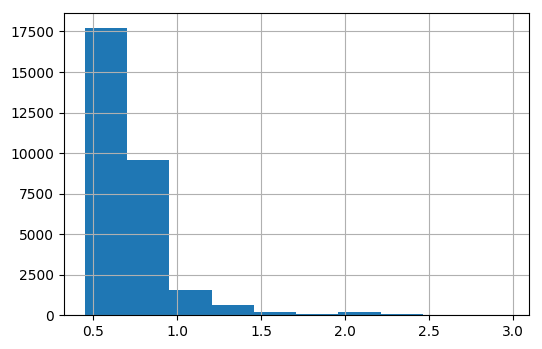

In [44]:
df_numpy['score'].hist()

In [39]:
df_numpy.head()

,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,amt_scaled,oldbalanceOrg_scaled,newbalanceOrig_scaled,oldbalanceDest_scaled,newbalanceDest_scaled,score
148,0,0,0,1,0,0.000023,0.000524,0.000586,0.000000,0.000000,0.701059
181,0,1,0,0,0,0.000620,0.000000,0.000000,0.000357,0.000180,0.499700
544,0,0,0,1,0,0.000083,0.000746,0.000742,0.000000,0.000000,0.721062
591,0,0,0,1,0,0.000104,0.001217,0.001269,0.000000,0.000000,0.711986
1012,0,1,0,0,0,0.005110,0.000440,0.000000,0.004329,0.009602,0.781554


In [40]:


import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 100


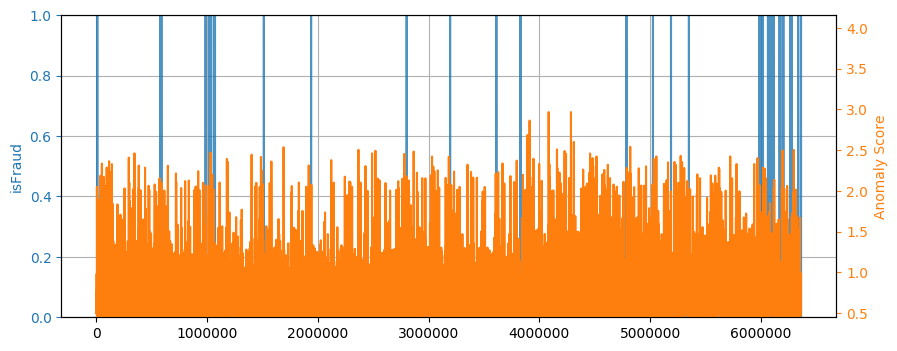

In [41]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the 
# anomaly found earlier in this notebook
#
start, end = 0, len(df_numpy)
#start, end = 5500, 6500
df_subset = df_numpy[start:end]

ax1.plot(labels['isFraud'], color='C0', alpha=0.8)
ax2.plot(df_numpy['score'], color='C1')

ax1.grid(which='major', axis='both')

ax1.set_ylabel('isFraud', color='C0')
ax2.set_ylabel('Anomaly Score', color='C1')

ax1.tick_params('y', colors='C0')
ax2.tick_params('y', colors='C1')

ax1.set_ylim(0, 1)
ax2.set_ylim(min(scores), 1.4*max(scores))
fig.set_figwidth(10)

In [80]:
from sklearn.metrics import average_precision_score
print('AUPRC = {}'.format(average_precision_score(labels.isFraud, \
                                              scores)))

AUPRC = 0.007697857572981637


In [122]:

y_actu = pd.Series([2, 0, 2, 2, 0, 1, 1, 2, 2, 0, 1, 2], name='Actual')
y_pred = pd.Series([0, 0, 2, 1, 0, 2, 1, 0, 2, 0, 2, 2], name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion

Predicted,0,1,2
Actual,,,
0,3,0,0
1,0,1,2
2,2,1,3


We will use approx 4 standard deviations from the mean as our threshold for fraud.

In [73]:
threshold = list(map(lambda x: 1 if x>= 1.2 else 0, scores))
print(threshold)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [74]:
Y = labels['isFraud']
#Y_small = Y[:6000]


In [75]:
y_actu = pd.Series(Y, name='Actual')
y_pred = pd.Series(threshold, name='Predicted')

In [76]:
from sklearn.metrics import confusion_matrix

In [77]:
confusion_matrix(y_actu, y_pred)

array([[28773,  1187],
       [   27,    13]])

In [78]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

In [79]:
print('Accuracy Score :',accuracy_score(y_actu, y_pred))
print('Report : ')
print(classification_report(y_actu, y_pred))

Accuracy Score : 0.9595333333333333
Report : 
             precision    recall  f1-score   support

          0       1.00      0.96      0.98     29960
          1       0.01      0.33      0.02        40

avg / total       1.00      0.96      0.98     30000



# Takeaways

* We need to improve our feature engineering
* We need to be able to pass a validation set to the algo so we can do hyperparameter tuning
* We could improve our visualizations
* With the current threshold, we our business would investigate around **1200 transactions**, while finding **13 actual fraudulent transactions**. We would still miss **27 fraudulent transactions**.
* We do not recommend deploying this model to production until the results are improved.

## Producton Deployment
* Once the performance is improved, we have 2 primary deployment options
  * Batch (less costly, but delayed)
  * Realtime (more expensive, but more timely)
  

In [32]:
# Delete the endpoint when finished
#sagemaker.Session().delete_endpoint(rcf_inference.endpoint)